## The project: Forecasting Daily Electricity Consumption per Cluster using Prophet

This project uses **Facebook Prophet** to forecast the next 7 days of average daily electricity consumption for each client cluster.

Each cluster's time series was modeled separately with **yearly and weekly seasonality**. The input data is the average daily consumption per cluster over time.

Unnecessary debug logs from `cmdstanpy` were suppressed for cleaner output.

---

### Forecast Results Summary

| Cluster | Forecast Quality    | Interpretation                                                                 |
| ------- | ------------------- | ------------------------------------------------------------------------------ |
| 0       | Correct & stable | Flat forecast matches low, stable consumption. Model behavior is appropriate.  |
| 1       | Excellent         | Strong seasonal pattern captured well. Forecast continues the trend naturally. |
| 2       | Good              | Trend is modeled smoothly. Forecast is realistic and stable.                   |
| 3       | Moderate         | Noisy pattern; Prophet smooths it. General direction is preserved.             |

---

### Conclusion

Prophet provides reliable forecasts for clusters with **clear patterns** (like Cluster 1 and 2), and performs acceptably even in **noisy or flat cases** (like Cluster 0 and 3). The results are useful for planning and monitoring electricity usage.


# The dataset: ElectricityLoadDiagrams20112014 Dataset Explanation

## Overview

The file `LD2011_2014.txt` is the core file of the **ElectricityLoadDiagrams20112014** dataset. It contains detailed electricity consumption measurements for hundreds of clients, recorded at regular 15-minute intervals, spanning from **January 1, 2011** to **December 31, 2014**.

This dataset is suitable for a wide range of **time series analysis** and **signal processing** tasks, including but not limited to:

* Anomaly detection
* Seasonality decomposition
* Forecasting (short-term and long-term)
* Customer segmentation
* Load clustering
* Energy demand profiling

## Structure

* **Rows**: Each row represents a single **timestamped reading**, recorded every **15 minutes**.
* **Columns**: Each column corresponds to a **unique client/metre ID** (e.g., `MT_001`, `MT_002`, ...).
* **Values**: Consumption values in **kilowatts (kW)**.

Example of the raw format:

| Timestamp           | MT_001 | MT_002 | MT_003 | ... |
| ------------------- | ------ | ------ | ------ | --- |
| 2011-01-01 00:15:00 | 1.118  | 1.055  | 1.175  | ... |
| 2011-01-01 00:30:00 | 1.102  | 1.067  | 1.156  | ... |
| ...                 | ...    | ...    | ...    | ... |


## Time Range

* **Start**: 2011-01-01 00:15:00
* **End**: 2014-12-31 23:45:00
* **Frequency**: Every 15 minutes
* **Total Duration**: 4 full years

## Data Characteristics

* More than **370 clients/meters**
* Some columns contain **missing values**, which should be filled using techniques like forward-fill or interpolation
* Data can be **resampled** to hourly, daily, or weekly levels depending on the use case
* Seasonal trends are clearly visible (e.g., daily/weekly cycles)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

# Path to the ZIP file in your Google Drive
zip_path = "/content/drive/MyDrive/Portfolio datasets/Signal processing/electricityloaddiagrams20112014.zip"

# Destination folder to extract to
extract_path = "/content/electricityLoadDiagrams20112014"
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to: {extract_path}")


Extracted to: /content/electricityLoadDiagrams20112014


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------
# Step 1: Load the file
# ----------------------------------------

file_path = "/content/electricityLoadDiagrams20112014/LD2011_2014.txt"

df = pd.read_csv(
    file_path,
    sep=";",
    index_col=0,
    parse_dates=True,
    decimal=","
)
df.index.name = "timestamp"
df.columns = [col.strip() for col in df.columns]

print("Raw shape:", df.shape)
print("df:", df.head())

Raw shape: (140256, 370)
df:                      MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
timestamp                                                                     
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
timestamp                                    ...                           
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0  

In [6]:
# Step 2: Create daily_profiles → reshape to clients × days

# Resample by day and sum kWh per day (assumes original freq = 15min)
daily_df = df.resample("D").sum()

# Transpose: now rows are clients, columns are days
daily_profiles = daily_df.T

print("Daily profiles shape (clients × days):", daily_profiles.shape)
daily_profiles.head()


from sklearn.cluster import KMeans

# Step 3: Cluster clients based on their daily profiles

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(daily_profiles)

# Create client_cluster_df
client_cluster_df = pd.DataFrame({
    "ClientID": daily_profiles.index,
    "Cluster": labels
})

# Group by cluster
cluster_groups = client_cluster_df.groupby("Cluster")["ClientID"].apply(list)




Daily profiles shape (clients × days): (370, 1462)


In [7]:
# Step 4: Filter only clients that are clustered
client_ids = client_cluster_df["ClientID"]
daily_profiles_filtered = daily_profiles.loc[client_ids]

# Step 5: Create artificial date range
start_date = pd.to_datetime("2011-01-01")
date_range = pd.date_range(start=start_date, periods=daily_profiles_filtered.shape[1], freq="D")


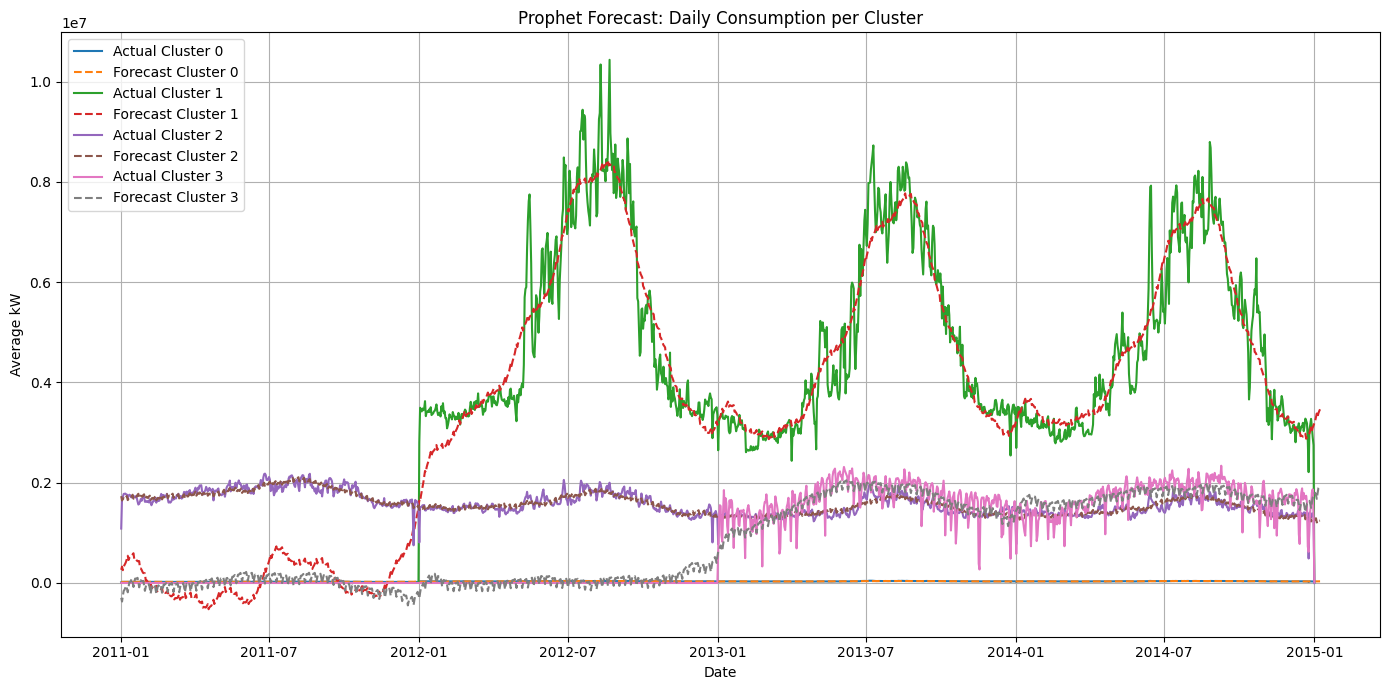

In [9]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import logging
# Silence Prophet / CmdStanPy logging
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)


plt.figure(figsize=(14, 7))

for cluster_id, client_ids in cluster_groups.items():
    cluster_data = daily_profiles_filtered.loc[client_ids]
    cluster_mean = cluster_data.mean(axis=0).values

    df_prophet = pd.DataFrame({
        "ds": date_range,
        "y": cluster_mean
    })

    model = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    plt.plot(df_prophet["ds"], df_prophet["y"], label=f"Actual Cluster {cluster_id}")
    plt.plot(forecast["ds"], forecast["yhat"], linestyle="--", label=f"Forecast Cluster {cluster_id}")

plt.title("Prophet Forecast: Daily Consumption per Cluster")
plt.xlabel("Date")
plt.ylabel("Average kW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
